In [46]:
import pandas as pd
from pathlib import Path
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder

## Inspect Dataframe

def inspect_dataframe(df)

In [47]:
def inspect_dataframe(df):
    # ทำสำเนาเพื่อความปลอดภัย (กันการแก้ไขของเดิมโดยไม่ตั้งใจ)
    df_safe = df.copy()

    print(f"Loaded {len(df_safe):,} rows × {len(df_safe.columns):,} columns")
    display(df_safe.head())

    print("\nDataFrame info:")
    df_safe.info()

    print("\nMissing values per column:")
    print(df_safe.isna().sum())
    print("----------------------------------------")

## drop_rows_with_nan

drop_rows_with_nan(df, cols, inplace=False)

In [48]:
def drop_rows_with_nan(df, cols, inplace=False):
    """
    Drop rows that have NaN in any column listed in `cols`.
    - df: pandas DataFrame
    - cols: list-like of column names to check for NaN
    - inplace: if True, modify df in-place and return it; otherwise return a new DataFrame
    """
    cols = list(cols)
    missing_cols = [c for c in cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

    before = len(df)
    result = df.dropna(subset=cols)
    mask_bad = result[cols].apply(lambda s: s.astype(str).str.strip().str.lower().eq("unknown")).any(axis=1)
    result = result[~mask_bad]
    after = len(result)
    print(f"Dropped {before - after} rows with NaN in {cols} (before: {before}, after: {after})")
    print("----------------------------------------")

    if inplace:
        # replace contents of original DataFrame
        df.drop(df.index, inplace=True)
        for col in result.columns:
            df[col] = result[col]
        return df
    return result

## add_time_range_and_filter

In [49]:
import pandas as pd

def add_time_range_and_filter(df, start_col="start", end_col="end", duration_col="duration_minutes"):
    """
    - Convert start/end columns to datetime
    - Remove rows where end < start
    - Add a column representing duration in minutes
    """
    df = df.copy()  # avoid modifying original df

    # Convert HH:MM string → datetime time-of-day
    df["_start_dt"] = pd.to_datetime(df[start_col], format="%H:%M", errors="coerce")
    df["_end_dt"]   = pd.to_datetime(df[end_col],   format="%H:%M", errors="coerce")

    # Count rows before filtering
    total_rows = len(df)

    # Identify invalid rows
    invalid_mask = df["_end_dt"] < df["_start_dt"]
    invalid_rows = df[invalid_mask]

    # Logging
    print("===== Time Range Cleaning Report =====")
    print(f"Total rows before cleaning : {total_rows}")
    print(f"Rows removed (end < start) : {len(invalid_rows)}")

    # Keep valid rows only
    df = df[~invalid_mask].copy()

    # Compute duration in minutes
    df[duration_col] = (df["_end_dt"] - df["_start_dt"]).dt.total_seconds() / 60.0
    df[range] = ( df["_start_dt"].dt.strftime("%H:%M") + " - " + df["_end_dt"].dt.strftime("%H:%M") )

    # Logging after cleaning
    print(f"Total rows after cleaning  : {len(df)}")
    print("======================================\n")

    # Drop helper columns
    df = df.drop(columns=["_start_dt", "_end_dt"])

    return df


## filter bangkok

In [50]:
import pandas as pd

def add_time_range_and_filter(
    df, 
    start_col="start", 
    end_col="end", 
    range_col="time_range", 
    duration_col="duration_minutes"
):
    """
    - Convert start/end columns to time
    - Remove rows where end < start
    - Add column showing time range string (start - end)
    - Add column showing duration in hours (float)
    """
    df = df.copy()

    # Convert HH:MM string → datetime
    df["_start_dt"] = pd.to_datetime(df[start_col], format="%H:%M", errors="coerce")
    df["_end_dt"]   = pd.to_datetime(df[end_col],   format="%H:%M", errors="coerce")

    # Count rows before cleaning
    total_rows = len(df)

    # Remove invalid rows (end < start)
    invalid_mask = df["_end_dt"] < df["_start_dt"]
    invalid_rows = df[invalid_mask]

    print("===== Time Range Cleaning Report =====")
    print(f"Total rows before cleaning : {total_rows}")
    print(f"Rows with end < start      : {len(invalid_rows)}")

    # Filter valid rows
    df = df[~invalid_mask].copy()

    # 1️⃣ Add new time range column ("HH:MM - HH:MM")
    df[range_col] = (
        df["_start_dt"].dt.strftime("%H:%M")
        + " - "
        + df["_end_dt"].dt.strftime("%H:%M")
    )

    # 2️⃣ Add duration (in hours)
    df[duration_col] = (df["_end_dt"] - df["_start_dt"]).dt.total_seconds() / 60.0

    print(f"Total rows after cleaning  : {len(df)}")
    print("======================================\n")

    # Clean helper columns
    df = df.drop(columns=["_start_dt", "_end_dt"])

    return df


## call Function

In [ ]:
# download data
path = Path("../data/scraping_data.csv")
if not path.exists():
    raise FileNotFoundError(f"{path} not found in {Path.cwd()}")

df_raw = pd.read_csv(path)

In [52]:
df = df_raw.copy()  # work on a copy to keep raw data intact

# 0.) inspect
inspect_dataframe(df)

# 1.) drop rows with nan
df = drop_rows_with_nan(df, ["date", "day_of_week", "start", "end", "location", "district", "province", "temp", "rain", "wind_gust"])

# 2.) add_time_range_and_filter 
df = add_time_range_and_filter(df)

# 3.) drop location
df = df.drop(columns='location')

# 4.) filter just bangkok
df = filter_bangkok(df, show_removed=True)

Loaded 11,355 rows × 10 columns


,date,day_of_week,start,end,location,district,province,temp,rain,wind_gust
0,2025-12-05,Friday,08:30,15:30,"Ratchaphruek Road, Soi nearby Rama 5 Road Roun...",Unknown,Nonthaburi,NaN,NaN,NaN
1,2025-12-05,Friday,08:30,15:30,The area along the side of Bang Kruai - Sai No...,Unknown,Nonthaburi,NaN,NaN,NaN
2,2025-12-04,Thursday,09:00,12:00,"Seri Thai Road, Soi Seri Thai 14, Bangchak Gas...",Bung Kum,Bangkok,NaN,NaN,NaN
3,2025-12-04,Thursday,09:00,14:00,"Pracha Ruam Chai Road, Soi Pracha Ruam Chai 45",Saen Khlong Tan,Bangkok,NaN,NaN,NaN
4,2025-12-04,Thursday,09:00,12:00,"Bypass Nonthaburi Road, the area nearby the be...",Unknown,Nonthaburi,NaN,NaN,NaN



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11355 entries, 0 to 11354
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         11355 non-null  object 
 1   day_of_week  11355 non-null  object 
 2   start        11355 non-null  object 
 3   end          11355 non-null  object 
 4   location     11355 non-null  object 
 5   district     11355 non-null  object 
 6   province     11355 non-null  object 
 7   temp         11322 non-null  float64
 8   rain         11322 non-null  float64
 9   wind_gust    11322 non-null  float64
dtypes: float64(3), object(7)
memory usage: 887.2+ KB

Missing values per column:
date            0
day_of_week     0
start           0
end             0
location        0
district        0
province        0
temp           33
rain           33
wind_gust      33
dtype: int64
----------------------------------------
Dropped 3175 rows with NaN in ['date', 'day_of_week', 

In [53]:
inspect_dataframe(df)

Loaded 6,745 rows × 11 columns


,date,day_of_week,start,end,district,province,temp,rain,wind_gust,time_range,duration_minutes
34,2025-11-26,Wednesday,08:30,13:30,Kannayao,Bangkok,23.343500,0.0,14.040000,08:30 - 13:30,300.0
35,2025-11-26,Wednesday,09:00,14:00,Thawi Watthana,Bangkok,23.343500,0.0,14.040000,09:00 - 14:00,300.0
38,2025-11-24,Monday,09:00,13:00,Taling Chan,Bangkok,24.843500,0.0,24.119999,09:00 - 13:00,240.0
41,2025-11-24,Monday,08:30,13:30,Lat Phrao,Bangkok,25.075998,0.0,24.119999,08:30 - 13:30,300.0
42,2025-11-23,Sunday,08:00,12:00,Phra Nakhon,Bangkok,22.893500,0.0,19.800000,08:00 - 12:00,240.0



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 6745 entries, 34 to 11354
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              6745 non-null   object 
 1   day_of_week       6745 non-null   object 
 2   start             6745 non-null   object 
 3   end               6745 non-null   object 
 4   district          6745 non-null   object 
 5   province          6745 non-null   object 
 6   temp              6745 non-null   float64
 7   rain              6745 non-null   float64
 8   wind_gust         6745 non-null   float64
 9   time_range        6745 non-null   object 
 10  duration_minutes  6745 non-null   float64
dtypes: float64(4), object(7)
memory usage: 632.3+ KB

Missing values per column:
date                0
day_of_week         0
start               0
end                 0
district            0
province            0
temp                0
rain                0
wind_gust 

In [54]:
# load .csv
df.to_csv("clean_scraping_data.csv", index=False, encoding="utf-8-sig")

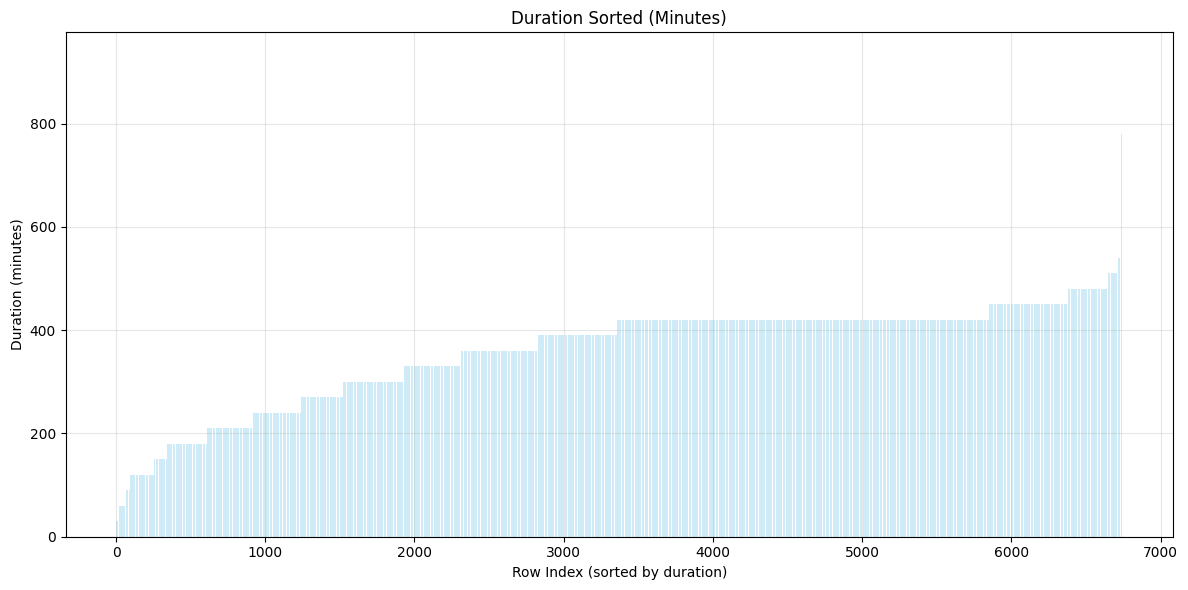

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Helper to convert HH:MM to minutes
# -------------------------------
def time_to_minutes(t):
    h, m = map(int, t.split(":"))
    return h * 60 + m

# -------------------------------
# Load CSV
# -------------------------------
df = pd.read_csv("../data/clean_scraping_data.csv")

# Convert to minutes
df["start_minutes"] = df["start"].apply(time_to_minutes)
df["end_minutes"]   = df["end"].apply(time_to_minutes)

# Duration (minutes)
df["duration"] = df["end_minutes"] - df["start_minutes"]

# -------------------------------
# SORT by duration (ascending)
# -------------------------------
df = df.sort_values("duration", ascending=True).reset_index(drop=True)

# New x-axis after sorting
x = range(len(df))

# -------------------------------
# Plot duration
# -------------------------------
plt.figure(figsize=(12, 6))
plt.bar(x, df["duration"], alpha=0.4, color="skyblue")

plt.title("Duration Sorted (Minutes)")
plt.xlabel("Row Index (sorted by duration)")
plt.ylabel("Duration (minutes)")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


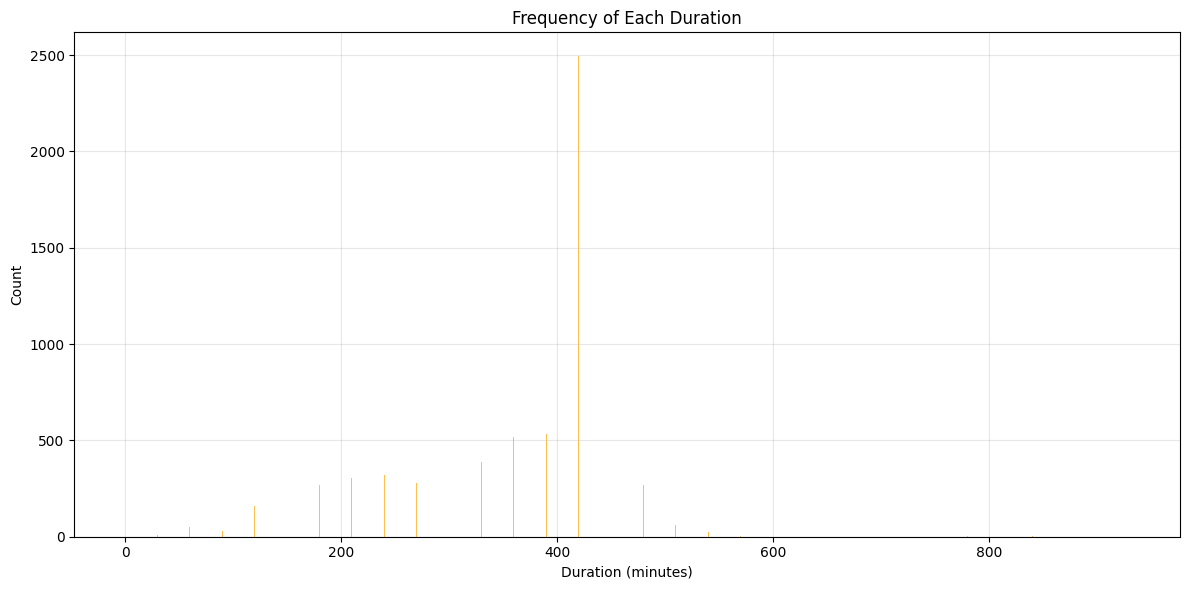

In [62]:
# Count each duration value
duration_counts = df["duration"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(duration_counts.index, duration_counts.values, color="orange", alpha=0.7)

plt.title("Frequency of Each Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


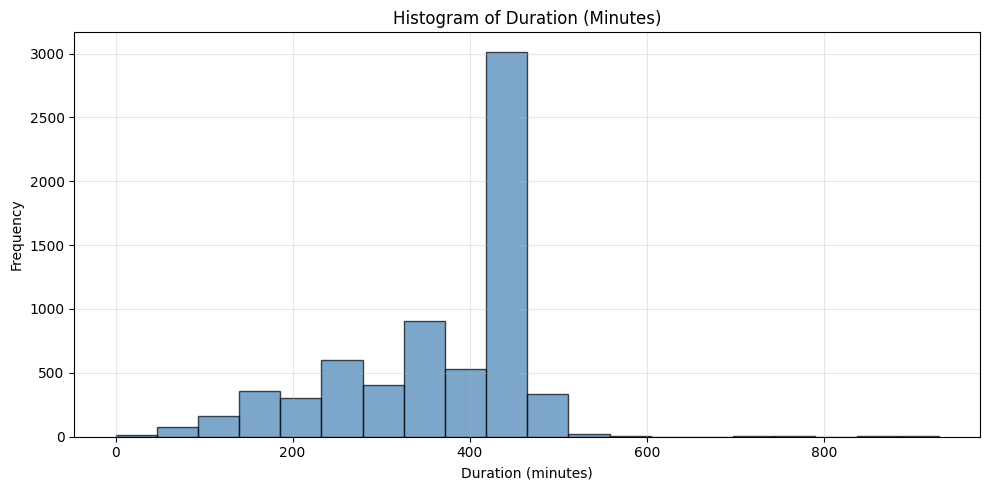

In [64]:
plt.figure(figsize=(10, 5))
plt.hist(df["duration"], bins=20, color="steelblue", alpha=0.7, edgecolor="black")

plt.title("Histogram of Duration (Minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
